In [ ]:
!git clone https://github.com/farelptraalbana/klasifikasi-faster-rcnn.git

fatal: destination path 'klasifikasi-faster-rcnn' already exists and is not an empty directory.


In [ ]:
%cd /content/klasifikasi-faster-rcnn

/content/klasifikasi-faster-rcnn


In [ ]:
!pip install torch==2.5.1

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Detected: Bungkus Makanan, Confidence: 0.9810
Detected: Botol Plastik, Confidence: 0.9460
Detected: Botol Plastik, Confidence: 0.9430
Detected: Bungkus Makanan, Confidence: 0.9160
Detected: Bungkus Makanan, Confidence: 0.7490


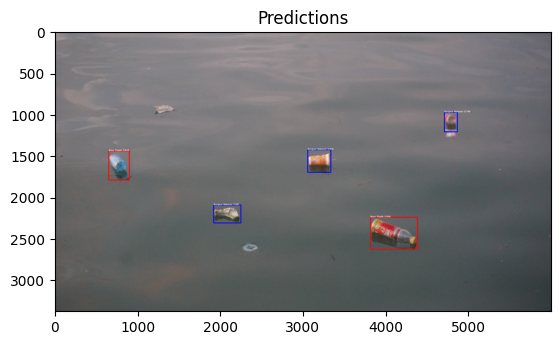

In [5]:
import torch
import numpy as np
import cv2
import os
import pandas as pd
import torchvision
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights

img_path = '/content/drive/MyDrive/SKRIPSI/pre_trained_model/resnet_50/SGD/learning_rate_2/hasil_klasifikasi/DSC02820.JPG'

labels_path = '/content/drive/MyDrive/SKRIPSI/pre_trained_model/resnet_50/SGD/learning_rate_2/labels.txt'

# Load labels dari Google Drive
with open(labels_path, 'r') as f:
    string = f.read()
    labels_dict = eval(string)

def get_model(num_classes):
    # Load a pre-trained object detection model (in this case, faster-rcnn)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

    # Number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Image processing
image = cv2.imread(img_path)
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img = torchvision.transforms.ToTensor()(img)

model_path = '/content/drive/MyDrive/SKRIPSI/pre_trained_model/resnet_50/SGD/learning_rate_2/model_50_epoch_resnet' # Path to model file in Google Drive

# Load model
loaded_model = get_model(num_classes=5) # Ensure num_classes matches the model saved

# Load weights into model
loaded_model.load_state_dict(torch.load(model_path, map_location='cpu', weights_only=True))

# Switch model to evaluation mode
loaded_model.eval()

# Make predictions
with torch.no_grad():
    prediction = loaded_model([img])

# Define color mapping for each label
color_map = {
    'Botol Plastik': (0, 0, 255),  # Red
    'Bungkus Makanan': (255, 0, 0),  # Blue
    'Bungkus Minuman': (0, 255, 255),  # Yellow
    'Kantong Plastik': (255, 0, 255),  # Purple
}

# Draw bounding boxes and add labels
for element in range(len(prediction[0]['boxes'])):
    x, y, w, h = prediction[0]['boxes'][element].numpy().astype(int)
    score = np.round(prediction[0]['scores'][element].numpy(), decimals=3)
    label_index = prediction[0]['labels'][element].numpy()
    label = labels_dict[int(label_index)]

    if score > 0.7:
        # Get the color based on the label
        box_color = color_map.get(label, (0, 255, 0))  # Default to green if label is not in color_map

        # Draw the rectangle and label with a fixed thickness
        thickness = 10  # Set a fixed thickness for all boxes
        cv2.rectangle(image, (x, y), (w, h), box_color, thickness)  # Box thickness is fixed
        text = str(label) + " " + str(score)
        cv2.putText(image, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8,
                    (255, 255, 255), 2)  # White text for readability

        # Print label and confidence score to console
        print(f"Detected: {label}, Confidence: {score:.4f}")

# Show the result
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Predictions")
plt.show()